# DBTL2: ART recommendations IN PROGRESS

This notebook demonstrates how ART can be used to model data from DBTL0 (single gRNA) and DBTL1 (double and triple gRNA) and make recommendations for new combiations of gRNA to increase isoprenol titer. 

This is part of the CRISPRi isoprenol project with David Carruthers and Taek Soon Lee. 

Tested using "ART Prod v.master.535f34c" kernel on skynet.ese.lbl and refactored ART.

## Input and output

TODO: Update this


Required files to run this notebook:

- Either: 
    - Isoprenol DBTL1 and DBTL0 files from experimental data depot OR
    - Local files containing DBTL1 and DBTL0 isoprenol titers
    
Outputs generated by running this notebook:
- Folder ``dbtl1_art_outputs`` 
    - Trained art model `art.cpkl`
    - predictions vs measurement plots for cross-validated and non-cross-validated model
    - cross-validated and non-cross-validated performance metrics.

- Folder ``dbtl1_figures_and_analysis.csv``
    - Figures from data analysis
    - `DBTL1_rec_df.pkl` A pickled dataframe containing all possible recommendations evaluated by ART for their predicted posterior mean and standard deviation


## 1. Setup

### 1.1 Imports
Data preprocessing imports

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random
random.seed(1)

ART imports

In [2]:
import os
import sys
from pathlib import Path
art_path = '../../'
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../') # Make sure this is the location for the ART library
sys.path.append(art_path)
import warning_utils
warning_utils.filter_end_user_warnings()

import copy
from IPython.display import Image  # Used to display images
import cloudpickle

from art.core import RecommendationEngine
import art.utility as utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### 1.2 User parameters

In [3]:
user_params = {
    'output_dir'  : './dbtl4_figures_and_analysis/',
    'max_guide_rnas': 4
}



### 1.3a Download the data

These are the [Experiment Data Depot](https://pubs.acs.org/doi/full/10.1021/acssynbio.7b00204) server, the corresponding username and the slug (address) for the study to be downloaded:

In [4]:
# study_slug_dbtl0 = 'crispri-automation-for-isoprenol-production-in-p-p'
# study_slug_dbtl1 = 'crispri-automation-for-enhanced-isoprenol-producti'
# edd_server   = 'edd.jbei.org'
# username     = 'pckinnunen'

# try:
#     session = eddu.login(edd_server=edd_server, user=username)
# except:
#     print('ERROR! Connection to EDD failed. We will try to load data from disk...')
# else:
#     print('OK! Connection to EDD successful. We will try to load data from EDD...')
    
    
    
# try:
#     df_dbtl0 = eddu.export_study(session, study_slug_dbtl0, edd_server=edd_server)
# except (NameError, AttributeError, KeyError):
#     print(f'ERROR! Not able to export DBTL0 study.')
    
# try:
#     df_dbtl1 = eddu.export_study(session, study_slug_dbtl1, edd_server = edd_server)
# except (NameError, AttributeError, KeyError):
#     print(f'ERROR! Not able to export DBTL1 study.')   

### 1.3b Get isoprenol data locally
I used the script `pull_edd_isoprenol.ipynb` to previously download the data from EDD and filter it to only contain isoprenol.

In [5]:
df_dbtl0 = pd.read_pickle('./isoprenol_data/dbtl0_isoprenol.pkl')
df_dbtl1 = pd.read_pickle('./isoprenol_data/dbtl1_isoprenol.pkl')
df_dbtl2 = pd.read_pickle('./isoprenol_data/dbtl2_isoprenol.pkl')
df_dbtl3 = pd.read_pickle('./isoprenol_data/dbtl3_isoprenol.pkl')
df_dbtl4 = pd.read_pickle('./isoprenol_data/dbtl4_isoprenol.pkl')

The only protocol left in the data is GC-FID, corresponding to isoprenol measurements.

In [6]:
df_dbtl0['Protocol'].unique()

array(['GC-FID'], dtype=object)

In [7]:
df_dbtl1['Protocol'].unique()

array(['GC-FID'], dtype=object)

In [8]:
df_dbtl2['Protocol'].unique()

array(['GC-FID'], dtype=object)

In [9]:
df_dbtl3['Protocol'].unique()

array(['GC-FID'], dtype=object)

In [10]:
df_dbtl4['Protocol'].unique()

array(['GC-FID'], dtype=object)

## 2. Data preprocessing

Compare the formats between datasets

In [11]:
df_dbtl0.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
594519,187352,CORRECTED: CRISPRi automation for enhanced iso...,187360,3475b66f-023e-4334-a86d-374b4094f346,Control-R1,BL1A1_NT,GC-FID,188815,Control-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,177.33700,24.0
594520,187352,CORRECTED: CRISPRi automation for enhanced iso...,187368,0445a7bc-3aaf-401a-a0c4-e77922997140,Control-R2,BL1B1_NT,GC-FID,188823,Control-R2,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,181.88373,24.0
594521,187352,CORRECTED: CRISPRi automation for enhanced iso...,187376,086e7c52-b5ac-42ca-81d1-e170b23b37fc,Control-R3,BL1C1_NT,GC-FID,188831,Control-R3,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,169.40580,24.0


In [12]:
df_dbtl1.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,188814,CRISPRi automation for enhanced isoprenol prod...,189546,ff8e234f-b5be-4251-8aba-62768f8a9167,PP_0226_PP_0897_PP_5288-R1,DBTL1_P1_001,GC-FID,189738,PP_0226_PP_0897_PP_5288-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,173.9811,24.0
1,188814,CRISPRi automation for enhanced isoprenol prod...,189547,97cf59b2-f9f2-4ce4-9cfb-34bf130ba140,PP_1319_PP_1457_PP_4192-R1,DBTL1_P1_002,GC-FID,189739,PP_1319_PP_1457_PP_4192-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,268.6526,24.0
2,188814,CRISPRi automation for enhanced isoprenol prod...,189548,c94ef30a-a46f-4ae0-9763-544159d054a9,PP_2213_PP_2471_PP_4266-R1,DBTL1_P1_003,GC-FID,189740,PP_2213_PP_2471_PP_4266-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,182.8489,24.0


In [13]:
df_dbtl2.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,194881,CRISPRi automation for enhanced isoprenol prod...,194882,c86dfaf3-ec02-463c-96c8-f8fe122b02cc,PP_0528_PP_0815_PP_1317_PP_4191-R1,DBTL2_P1_001,GC-FID,195074,PP_0528_PP_0815_PP_1317_PP_4191-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,201.9179,48.0
1,194881,CRISPRi automation for enhanced isoprenol prod...,194883,c76bdfef-08b8-463c-8c1e-324e10fe5eee,PP_0528_PP_0813_PP_0815_PP_1317-R1,DBTL2_P1_002,GC-FID,195075,PP_0528_PP_0813_PP_0815_PP_1317-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,392.7469,48.0
2,194881,CRISPRi automation for enhanced isoprenol prod...,194884,0d59d68e-24f6-4d82-9235-787339f485bd,PP_0528_PP_0814_PP_0815_PP_1317-R1,DBTL2_P1_003,GC-FID,195076,PP_0528_PP_0814_PP_0815_PP_1317-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,457.0174,48.0


In [14]:
df_dbtl3.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
411384,209320,CRISPRi automation for enhanced isoprenol prod...,209321,e2158e3d-338a-47f9-86b1-84d7fef4ec5d,PP_0528_PP_0813_PP_0815_PP_1317-R1,DBTL3_P1_001,GC-FID,209687,PP_0528_PP_0813_PP_0815_PP_1317-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,473.4303,48.0
411385,209320,CRISPRi automation for enhanced isoprenol prod...,209322,ad8c49c3-353e-4c7b-a91e-e5700823c491,PP_0528_PP_0813_PP_4191-R1,DBTL3_P1_002,GC-FID,209688,PP_0528_PP_0813_PP_4191-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,325.8933,48.0
411386,209320,CRISPRi automation for enhanced isoprenol prod...,209323,ab040beb-fef0-4ffa-a63f-bfaffc18fc6f,PP_0528_PP_0814_PP_4191-R1,DBTL3_P1_003,GC-FID,209689,PP_0528_PP_0814_PP_4191-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,372.1794,48.0


In [15]:
df_dbtl4.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,211976,CRISPRi automation for enhanced isoprenol prod...,211977,4d3d53db-7352-42aa-8303-91a28fcda44b,PP_0368_PP_0812_PP_0813-R1,DBTL4_P1_001,GC-FID,212307,PP_0368_PP_0812_PP_0813-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,458.8593,48.0
1,211976,CRISPRi automation for enhanced isoprenol prod...,211978,a9309f66-2c5f-462b-8c8c-1df3b0152a8d,PP_0368_PP_0812_PP_0815-R1,DBTL4_P1_002,GC-FID,212308,PP_0368_PP_0812_PP_0815-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,713.6108,48.0
2,211976,CRISPRi automation for enhanced isoprenol prod...,211979,6daab9e9-3647-47c9-93dc-d5aa33dc7f2f,PP_0751_PP_0812_PP_0814-R1,DBTL4_P1_003,GC-FID,212309,PP_0751_PP_0812_PP_0814-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,410.4078,48.0


### 2.1 Process individual dataframes

#### 2.1.1 Break out replicate information
The `Line Name` columns in each dataframe contains the replicate information at the end as -RXX. Take the replicate information from the `Line Name` and save it as a separate column.

First, fix one data entry error - control labeled as rep 4.

In [16]:
df_dbtl1[df_dbtl1['Line Name'] == 'Control_P2-R4']

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
79,188814,CRISPRi automation for enhanced isoprenol prod...,189721,5f6c1e93-852a-4f1f-ac4b-3b4ca0fc29e5,Control_P2-R4,DBTL1_P1_032,GC-FID,189913,Control_P2-R4,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,145.0277,24.0


In [17]:
df_dbtl1.loc[df_dbtl1['Line Name'] == 'Control_P2-R4', ['Line Name', 'Assay Name']] = 'Control_P2-R1'

In [18]:
def add_replicate_number(x):
    rep_position = x.find('-R')+2
    return int(x[rep_position:])
df_dbtl0['rep'] = df_dbtl0['Line Name'].apply(add_replicate_number)
df_dbtl1['rep'] = df_dbtl1['Line Name'].apply(add_replicate_number)
df_dbtl2['rep'] = df_dbtl2['Line Name'].apply(add_replicate_number)
df_dbtl3['rep'] = df_dbtl3['Line Name'].apply(add_replicate_number)
df_dbtl4['rep'] = df_dbtl4['Line Name'].apply(add_replicate_number)

Remove replicate information from the `Line Name`

In [19]:
add_line_name = lambda x: x.split('-')[0]
df_dbtl0['line_name_norep'] = df_dbtl0['Line Name'].apply(add_line_name)
df_dbtl1['line_name_norep'] = df_dbtl1['Line Name'].apply(add_line_name)
df_dbtl2['line_name_norep'] = df_dbtl2['Line Name'].apply(add_line_name)
df_dbtl3['line_name_norep'] = df_dbtl3['Line Name'].apply(add_line_name)
df_dbtl4['line_name_norep'] = df_dbtl4['Line Name'].apply(add_line_name)

In [20]:
df_dbtl1.shape

(192, 17)

#### 2.1.2 Drop plate information from dbtl1 dataframe
David included the plate that each control is in for DBTL1. I don't need that information so dropping it.

In [21]:
filter_control_name = lambda x: 'Control' if 'ontrol' in x else x
df_dbtl1['line_name_norep'] = df_dbtl1['line_name_norep'].apply(filter_control_name)
df_dbtl2['line_name_norep'] = df_dbtl2['line_name_norep'].apply(filter_control_name)

In [22]:
df_dbtl1.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours,rep,line_name_norep
0,188814,CRISPRi automation for enhanced isoprenol prod...,189546,ff8e234f-b5be-4251-8aba-62768f8a9167,PP_0226_PP_0897_PP_5288-R1,DBTL1_P1_001,GC-FID,189738,PP_0226_PP_0897_PP_5288-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,173.9811,24.0,1,PP_0226_PP_0897_PP_5288
1,188814,CRISPRi automation for enhanced isoprenol prod...,189547,97cf59b2-f9f2-4ce4-9cfb-34bf130ba140,PP_1319_PP_1457_PP_4192-R1,DBTL1_P1_002,GC-FID,189739,PP_1319_PP_1457_PP_4192-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,268.6526,24.0,1,PP_1319_PP_1457_PP_4192
2,188814,CRISPRi automation for enhanced isoprenol prod...,189548,c94ef30a-a46f-4ae0-9763-544159d054a9,PP_2213_PP_2471_PP_4266-R1,DBTL1_P1_003,GC-FID,189740,PP_2213_PP_2471_PP_4266-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,182.8489,24.0,1,PP_2213_PP_2471_PP_4266


In [23]:
df_dbtl2.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours,rep,line_name_norep
0,194881,CRISPRi automation for enhanced isoprenol prod...,194882,c86dfaf3-ec02-463c-96c8-f8fe122b02cc,PP_0528_PP_0815_PP_1317_PP_4191-R1,DBTL2_P1_001,GC-FID,195074,PP_0528_PP_0815_PP_1317_PP_4191-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,201.9179,48.0,1,PP_0528_PP_0815_PP_1317_PP_4191
1,194881,CRISPRi automation for enhanced isoprenol prod...,194883,c76bdfef-08b8-463c-8c1e-324e10fe5eee,PP_0528_PP_0813_PP_0815_PP_1317-R1,DBTL2_P1_002,GC-FID,195075,PP_0528_PP_0813_PP_0815_PP_1317-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,392.7469,48.0,1,PP_0528_PP_0813_PP_0815_PP_1317
2,194881,CRISPRi automation for enhanced isoprenol prod...,194884,0d59d68e-24f6-4d82-9235-787339f485bd,PP_0528_PP_0814_PP_0815_PP_1317-R1,DBTL2_P1_003,GC-FID,195076,PP_0528_PP_0814_PP_0815_PP_1317-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,457.0174,48.0,1,PP_0528_PP_0814_PP_0815_PP_1317


In [24]:
df_dbtl3.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours,rep,line_name_norep
411384,209320,CRISPRi automation for enhanced isoprenol prod...,209321,e2158e3d-338a-47f9-86b1-84d7fef4ec5d,PP_0528_PP_0813_PP_0815_PP_1317-R1,DBTL3_P1_001,GC-FID,209687,PP_0528_PP_0813_PP_0815_PP_1317-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,473.4303,48.0,1,PP_0528_PP_0813_PP_0815_PP_1317
411385,209320,CRISPRi automation for enhanced isoprenol prod...,209322,ad8c49c3-353e-4c7b-a91e-e5700823c491,PP_0528_PP_0813_PP_4191-R1,DBTL3_P1_002,GC-FID,209688,PP_0528_PP_0813_PP_4191-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,325.8933,48.0,1,PP_0528_PP_0813_PP_4191
411386,209320,CRISPRi automation for enhanced isoprenol prod...,209323,ab040beb-fef0-4ffa-a63f-bfaffc18fc6f,PP_0528_PP_0814_PP_4191-R1,DBTL3_P1_003,GC-FID,209689,PP_0528_PP_0814_PP_4191-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,372.1794,48.0,1,PP_0528_PP_0814_PP_4191


#### 2.1.3 Filter out data from DBTL1
Numerous strains in DBTL1 didn't exhibit high enough dCas9 or low enough target protein expression. We filtered them out in `analyze_proteomics_DBTL1.ipynb`.

In [25]:
dbtl1_filter_df = pd.read_csv('./dbtl1_proteomics_analysis/filtered_lines_df_dcas9thresh_0.25_targetthresh_0.5.csv', index_col=0)
dbtl1_filter_df

,Line Name,line_name_norep,to_keep
0,PP_0226_PP_0897_PP_5288-R1,PP_0226_PP_0897_PP_5288,True
2,PP_2213_PP_2471_PP_4266-R1,PP_2213_PP_2471_PP_4266,True
3,PP_3123_PP_4862_PP_5186-R1,PP_3123_PP_4862_PP_5186,True
5,PP_4189_PP_4550_PP_4862-R1,PP_4189_PP_4550_PP_4862,True
8,PP_0226_PP_0897_PP_5288-R2,PP_0226_PP_0897_PP_5288,True
...,...,...,...
183,Control_P4-R2,Control,True
185,PP_0813_PP_4189-R3,PP_0813_PP_4189,True
187,PP_0437_PP_3365-R3,PP_0437_PP_3365,True
188,PP_1319_PP_4121_PP_4667-R3,PP_1319_PP_4121_PP_4667,True


In [26]:
def check_filter_dataframe(line_name, filter_df):
    return np.any(filter_df['Line Name'].values == line_name)

In [27]:
df_dbtl1.loc[:,'dbtl1_filter'] = df_dbtl1['Line Name'].apply(lambda x: check_filter_dataframe(x, dbtl1_filter_df))
df_dbtl0.loc[:,'dbtl1_filter'] = True
df_dbtl2.loc[:,'dbtl1_filter'] = True
df_dbtl3.loc[:,'dbtl1_filter'] = True
df_dbtl4.loc[:,'dbtl1_filter'] = True

#### 2.1.3 Add column for non-template information in DBTL0
Some Lines are defined by an extra identifier for non-template information - For instance, line names like `PP_1607_NT1` or `PP_1607_NT1_xylS_Pm`. The NT indicates that a different non-template 

Define a function to get the string after NT in the line name:

In [28]:
def extract_nt_information(line_name):
    if '_NT' in line_name:
        return 'NT'+line_name.split('_NT')[1]
    else: 
        return None

Save the NT information in a separate dataframe.

In [29]:
df_dbtl0['nt_string'] = df_dbtl0['line_name_norep'].apply(extract_nt_information)
df_dbtl1['nt_string'] = df_dbtl1['line_name_norep'].apply(extract_nt_information)
df_dbtl2['nt_string'] = df_dbtl2['line_name_norep'].apply(extract_nt_information)
df_dbtl3['nt_string'] = df_dbtl3['line_name_norep'].apply(extract_nt_information)
df_dbtl4['nt_string'] = df_dbtl4['line_name_norep'].apply(extract_nt_information)

Remove NT information from `line_name_norep`.

In [30]:
remove_nt_information = lambda x: x.split('_NT')[0]
df_dbtl0['line_name_norep'] = df_dbtl0['line_name_norep'].apply(remove_nt_information)

#### 2.1.4 Filter out dbtl2 data

In [31]:
dbtl2_filter_df = pd.read_csv('./dbtl2_proteomics_analysis/filtered_lines_df_dcas9thresh_0.25_targetthresh_0.5.csv', index_col=0)
dbtl2_filter_df

,Line Name,line_name_norep,to_keep_improved
74,PP_0751_PP_0813_PP_4189-R1,PP_0751_PP_0813_PP_4189,True
82,PP_0751_PP_0813_PP_4189-R2,PP_0751_PP_0813_PP_4189,True
90,PP_0751_PP_0813_PP_4189-R3,PP_0751_PP_0813_PP_4189,True
97,PP_0528_PP_4120_PP_4191-R1,PP_0528_PP_4120_PP_4191,True
98,PP_0528_PP_0751_PP_0813-R1,PP_0528_PP_0751_PP_0813,True
100,PP_0813_PP_0814-R1,PP_0813_PP_0814,True
105,PP_0528_PP_4120_PP_4191-R2,PP_0528_PP_4120_PP_4191,True
106,PP_0528_PP_0751_PP_0813-R2,PP_0528_PP_0751_PP_0813,True
108,PP_0813_PP_0814-R2,PP_0813_PP_0814,True
113,PP_0528_PP_4120_PP_4191-R3,PP_0528_PP_4120_PP_4191,True


In [32]:
df_dbtl2.loc[:,'dbtl2_filter'] = df_dbtl2['Line Name'].apply(lambda x: check_filter_dataframe(x, dbtl2_filter_df))
df_dbtl0.loc[:,'dbtl2_filter'] = True
df_dbtl1.loc[:,'dbtl2_filter'] = True
df_dbtl3.loc[:,'dbtl2_filter'] = True
df_dbtl4.loc[:,'dbtl2_filter'] = True

#### 2.1.4 Filter out dbtl3 data

In [33]:
dbtl3_filter_df = pd.read_csv('./dbtl3_proteomics_analysis/filtered_lines_df_dcas9thresh_0.25_targetthresh_0.5.csv', index_col=0)
dbtl3_filter_df

,Line Name,line_name_norep,to_keep_improved
0,Control_P1-R1,Control,True
1,Control_P1-R2,Control,True
2,Control_P1-R3,Control,True
3,Control_P2-R1,Control,True
4,Control_P2-R2,Control,True
...,...,...,...
169,PP_2136_PP_4189-R2,PP_2136_PP_4189,True
170,PP_2136_PP_4189-R3,PP_2136_PP_4189,True
171,PP_4189_PP_4192-R1,PP_4189_PP_4192,True
172,PP_4189_PP_4192-R2,PP_4189_PP_4192,True


In [34]:
df_dbtl3['Line Name']

411384    PP_0528_PP_0813_PP_0815_PP_1317-R1
411385            PP_0528_PP_0813_PP_4191-R1
411386            PP_0528_PP_0814_PP_4191-R1
411387            PP_0528_PP_0751_PP_4191-R1
411388            PP_0528_PP_0815_PP_4191-R1
                         ...                
411562                    PP_0815_PP_1317-R3
411563         PP_0528_PP_0815_PP_1317_P4-R3
411564                    PP_0812_PP_1769-R3
411565                 PP_0368_PP_4189_P4-R3
411566                         Control_P4-R3
Name: Line Name, Length: 183, dtype: object

In [35]:
np.any(dbtl3_filter_df['Line Name'].values == 'PP_0528_PP_0813_PP_0815_PP_1317-R1')

False

In [36]:
df_dbtl3.loc[:,'dbtl3_filter'] = df_dbtl3['Line Name'].apply(lambda x: check_filter_dataframe(x, dbtl3_filter_df))
df_dbtl0.loc[:,'dbtl3_filter'] = True
df_dbtl1.loc[:,'dbtl3_filter'] = True
df_dbtl2.loc[:,'dbtl3_filter'] = True
df_dbtl4.loc[:,'dbtl3_filter'] = True

#### 2.1.4 Filter out dbtl4 data

In [37]:
dbtl4_filter_df = pd.read_csv('./dbtl4_figures_and_analysis/filtered_lines_df_dcas9thresh_0.25_targetthresh_0.5.csv', index_col=0)
dbtl4_filter_df

,Line Name,line_name_norep,to_keep_improved
0,PP_0368_PP_0812_PP_0813-R1,PP_0368_PP_0812_PP_0813,True
1,PP_0368_PP_0812_PP_0815-R1,PP_0368_PP_0812_PP_0815,True
2,PP_0751_PP_0812_PP_0814-R1,PP_0751_PP_0812_PP_0814,True
3,PP_0751_PP_0813_PP_0814-R1,PP_0751_PP_0813_PP_0814,True
4,PP_0751_PP_0814_PP_4191-R1,PP_0751_PP_0814_PP_4191,True
...,...,...,...
173,PP_1506_PP_4189-R2,PP_1506_PP_4189,True
176,Control_P4-R2,Control,True
177,PP_0815_PP_4189-R3,PP_0815_PP_4189,True
179,PP_1506_PP_4189-R3,PP_1506_PP_4189,True


In [38]:
df_dbtl3['Line Name']

411384    PP_0528_PP_0813_PP_0815_PP_1317-R1
411385            PP_0528_PP_0813_PP_4191-R1
411386            PP_0528_PP_0814_PP_4191-R1
411387            PP_0528_PP_0751_PP_4191-R1
411388            PP_0528_PP_0815_PP_4191-R1
                         ...                
411562                    PP_0815_PP_1317-R3
411563         PP_0528_PP_0815_PP_1317_P4-R3
411564                    PP_0812_PP_1769-R3
411565                 PP_0368_PP_4189_P4-R3
411566                         Control_P4-R3
Name: Line Name, Length: 183, dtype: object

In [39]:
np.any(dbtl3_filter_df['Line Name'].values == 'PP_0528_PP_0813_PP_0815_PP_1317-R1')

False

In [40]:
df_dbtl4.loc[:,'dbtl4_filter'] = df_dbtl4['Line Name'].apply(lambda x: check_filter_dataframe(x, dbtl4_filter_df))
df_dbtl0.loc[:,'dbtl4_filter'] = True
df_dbtl1.loc[:,'dbtl4_filter'] = True
df_dbtl2.loc[:,'dbtl4_filter'] = True
df_dbtl3.loc[:,'dbtl4_filter'] = True

### 2.2 Merge dataframes
At this point, the dataframes have the same columns and formatting, so I can merge them.

First, test that columns match:

In [41]:
assert(np.all(np.sort(df_dbtl0.columns) == np.sort(df_dbtl1.columns))), 'ERROR: dbtl1 and dbtl0 dataframe columns do not match before merging'

In [42]:
df_dbtl0.columns

Index(['Study ID', 'Study Name', 'Line ID', 'Replicate Key', 'Line Name',
       'Line Description', 'Protocol', 'Assay ID', 'Assay Name', 'Formal Type',
       'Measurement Type', 'Compartment', 'Units', 'Value', 'Hours', 'rep',
       'line_name_norep', 'dbtl1_filter', 'nt_string', 'dbtl2_filter',
       'dbtl3_filter', 'dbtl4_filter'],
      dtype='object')

In [43]:
df_dbtl2.columns

Index(['Study ID', 'Study Name', 'Line ID', 'Replicate Key', 'Line Name',
       'Line Description', 'Protocol', 'Assay ID', 'Assay Name', 'Formal Type',
       'Measurement Type', 'Compartment', 'Units', 'Value', 'Hours', 'rep',
       'line_name_norep', 'dbtl1_filter', 'nt_string', 'dbtl2_filter',
       'dbtl3_filter', 'dbtl4_filter'],
      dtype='object')

In [44]:
assert(np.all(np.sort(df_dbtl0.columns) == np.sort(df_dbtl2.columns))), 'ERROR: dbtl1 and dbtl0 dataframe columns do not match before merging'

Add `cycle` column to each dataframe:

In [45]:
df_dbtl0['cycle'] = 0
df_dbtl1['cycle'] = 1
df_dbtl2['cycle'] = 2
df_dbtl3['cycle'] = 3
df_dbtl4['cycle'] = 4

Merge dataframes and reset index

In [46]:
df = pd.concat([df_dbtl0, df_dbtl1, df_dbtl2, df_dbtl3, df_dbtl4], axis = 0).reset_index(drop = True)
df.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,...,Value,Hours,rep,line_name_norep,dbtl1_filter,nt_string,dbtl2_filter,dbtl3_filter,dbtl4_filter,cycle
0,187352,CORRECTED: CRISPRi automation for enhanced iso...,187360,3475b66f-023e-4334-a86d-374b4094f346,Control-R1,BL1A1_NT,GC-FID,188815,Control-R1,cid:12988,...,177.33700,24.0,1,Control,True,None,True,True,True,0
1,187352,CORRECTED: CRISPRi automation for enhanced iso...,187368,0445a7bc-3aaf-401a-a0c4-e77922997140,Control-R2,BL1B1_NT,GC-FID,188823,Control-R2,cid:12988,...,181.88373,24.0,2,Control,True,None,True,True,True,0
2,187352,CORRECTED: CRISPRi automation for enhanced iso...,187376,086e7c52-b5ac-42ca-81d1-e170b23b37fc,Control-R3,BL1C1_NT,GC-FID,188831,Control-R3,cid:12988,...,169.40580,24.0,3,Control,True,None,True,True,True,0


### 2.3 Add control field
Add a column to the dataframe indicating whether the data is for a control

In [47]:
boolean_control_check = lambda x: 1 if 'ontrol' in x else 0
df['is_control'] = df['line_name_norep'].apply(boolean_control_check).astype(bool)

In [48]:
assert(df['Measurement Type'].unique() == ['3-METHYL-3-BUTEN-1-OL']), 'ERROR: Some df[Measurement Type]s are not isoprenol.'

### 2.4 Add columns for each guide RNA position
We will add a column containing a sorted list of gRNA targets (`sorted_gene_list`), columns for the gene target at each gRNA position (`gRNA_1`, `gRNA_2`, `...`), and a column for the number of gRNA in each line (`number_of_grna`).

#### 2.4.1 Add sorted gene list to dataframe

Write a function to parse the line name and turn it into a list with entries ['PP_XXXX', 'PP_YYYY', ...] using regex. Function finds all instances of the pattern 'PP_XXXX' where each X is a number.

Function returns an empty np.array() for control strains.

In [49]:
def add_sorted_gene_list(line_name_norep):
    if 'Control' in line_name_norep:
        return np.array([])
    else:
        return np.sort(re.findall('PP_[0-9]{4}', line_name_norep))

Apply function to add the sorted gene list to the dataframe.

In [50]:
df['sorted_gene_list']= df['line_name_norep'].apply(add_sorted_gene_list)
df.tail(5)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,...,rep,line_name_norep,dbtl1_filter,nt_string,dbtl2_filter,dbtl3_filter,dbtl4_filter,cycle,is_control,sorted_gene_list
1153,211976,CRISPRi automation for enhanced isoprenol prod...,212158,9d422bdc-a247-4063-a209-462d67e00c71,PP_1317_PP_4189-R3,DBTL4_P4_042,GC-FID,212488,PP_1317_PP_4189-R3,cid:12988,...,3,PP_1317_PP_4189,True,None,True,True,False,4,False,"[PP_1317, PP_4189]"
1154,211976,CRISPRi automation for enhanced isoprenol prod...,212159,f41a93f2-acc6-408c-92c7-b98ed8e030bb,PP_1506_PP_4189-R3,DBTL4_P4_043,GC-FID,212489,PP_1506_PP_4189-R3,cid:12988,...,3,PP_1506_PP_4189,True,None,True,True,True,4,False,"[PP_1506, PP_4189]"
1155,211976,CRISPRi automation for enhanced isoprenol prod...,212160,fccc0c86-8860-4636-8ad0-27c962c5628d,PP_4120_PP_4189-R3,DBTL4_P4_044,GC-FID,212490,PP_4120_PP_4189-R3,cid:12988,...,3,PP_4120_PP_4189,True,None,True,True,False,4,False,"[PP_4120, PP_4189]"
1156,211976,CRISPRi automation for enhanced isoprenol prod...,212161,01e75da1-0919-42a9-a3cd-b8551cea8a39,PP_4189_PP_4191-R3,DBTL4_P4_045,GC-FID,212491,PP_4189_PP_4191-R3,cid:12988,...,3,PP_4189_PP_4191,True,None,True,True,False,4,False,"[PP_4189, PP_4191]"
1157,211976,CRISPRi automation for enhanced isoprenol prod...,212162,2dee6b9f-be8e-4f1e-b4fe-e2941149b597,Control_P4-R3,DBTL4_P4_048,GC-FID,212492,Control_P4-R3,cid:12988,...,3,Control_P4,True,None,True,True,True,4,True,[]


#### 2.4.2 Fill in gRNA position columns

Add columns to df corresponding to a list of altered genes, and add individual columns corresponding to the gRNA at specific positions.

In [51]:
grna_columns = [f'gRNA_{i}' for i in range(1, user_params['max_guide_rnas']+1)]
grna_columns

['gRNA_1', 'gRNA_2', 'gRNA_3', 'gRNA_4']

Add gRNA columns to dataframe:

In [52]:
for g in grna_columns:
    df[g] = 'None'

Now, use the sorted gene list to fill in individual `gRNA_1`, `gRNA_2`, `...` columns. 

Define function operating on `gene_list` that returns the gene at a specified position, or returns None if the gene list doesn't have anything in that position 

In [53]:
def return_gene_from_genelist(gene_list, position):
    if position>=len(gene_list):
        return None
    else:
        return gene_list[position]

Iterate through positions in the `sorted_gene_list` and fill in `gRNA_X` column.

In [54]:
for g_idx, g in enumerate(grna_columns):
    df[g] = df['sorted_gene_list'].apply(lambda x: return_gene_from_genelist(x, g_idx))

Finally, add a column for the number of genes manipulated

In [55]:
count_number_of_grna = lambda x: len(x)
df['number_of_grna'] = df['sorted_gene_list'].apply(len)

### 2.5 Rename `Value` column to `isoprenol`
All measurements in the dataframe are isoprenol, so rename the column to be more clear.

In [56]:
df = df.rename(columns={'Value':'isoprenol'})

In [57]:
df.head()

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,...,dbtl3_filter,dbtl4_filter,cycle,is_control,sorted_gene_list,gRNA_1,gRNA_2,gRNA_3,gRNA_4,number_of_grna
0,187352,CORRECTED: CRISPRi automation for enhanced iso...,187360,3475b66f-023e-4334-a86d-374b4094f346,Control-R1,BL1A1_NT,GC-FID,188815,Control-R1,cid:12988,...,True,True,0,True,[],None,None,None,None,0
1,187352,CORRECTED: CRISPRi automation for enhanced iso...,187368,0445a7bc-3aaf-401a-a0c4-e77922997140,Control-R2,BL1B1_NT,GC-FID,188823,Control-R2,cid:12988,...,True,True,0,True,[],None,None,None,None,0
2,187352,CORRECTED: CRISPRi automation for enhanced iso...,187376,086e7c52-b5ac-42ca-81d1-e170b23b37fc,Control-R3,BL1C1_NT,GC-FID,188831,Control-R3,cid:12988,...,True,True,0,True,[],None,None,None,None,0
3,187352,CORRECTED: CRISPRi automation for enhanced iso...,187408,8d8b104b-b36a-4c30-b5d9-1449e73fb218,Control-R4,BL2A1_NT,GC-FID,188863,Control-R4,cid:12988,...,True,True,0,True,[],None,None,None,None,0
4,187352,CORRECTED: CRISPRi automation for enhanced iso...,187416,63f68f0d-d4a8-4b64-b1ba-8412da15aecb,Control-R5,BL2B1_NT,GC-FID,188871,Control-R5,cid:12988,...,True,True,0,True,[],None,None,None,None,0


### 2.6 Drop extra columns
There are several unnecessary columns we can get rid of.

In [58]:
columns_to_keep = ['Line Name', 'Line Description', 'Units', 'isoprenol', 'rep', 'line_name_norep', 'nt_string', 'cycle', 'is_control', 'sorted_gene_list', 'number_of_grna', 'dbtl1_filter', 'dbtl3_filter', 'dbtl4_filter'] + grna_columns
df = df.loc[:,columns_to_keep]
df

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,number_of_grna,dbtl1_filter,dbtl3_filter,dbtl4_filter,gRNA_1,gRNA_2,gRNA_3,gRNA_4
0,Control-R1,BL1A1_NT,mg/L,177.33700,1,Control,None,0,True,[],0,True,True,True,None,None,None,None
1,Control-R2,BL1B1_NT,mg/L,181.88373,2,Control,None,0,True,[],0,True,True,True,None,None,None,None
2,Control-R3,BL1C1_NT,mg/L,169.40580,3,Control,None,0,True,[],0,True,True,True,None,None,None,None
3,Control-R4,BL2A1_NT,mg/L,161.67620,4,Control,None,0,True,[],0,True,True,True,None,None,None,None
4,Control-R5,BL2B1_NT,mg/L,136.42987,5,Control,None,0,True,[],0,True,True,True,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,PP_1317_PP_4189-R3,DBTL4_P4_042,mg/L,236.18310,3,PP_1317_PP_4189,None,4,False,"[PP_1317, PP_4189]",2,True,True,False,PP_1317,PP_4189,None,None
1154,PP_1506_PP_4189-R3,DBTL4_P4_043,mg/L,330.69330,3,PP_1506_PP_4189,None,4,False,"[PP_1506, PP_4189]",2,True,True,True,PP_1506,PP_4189,None,None
1155,PP_4120_PP_4189-R3,DBTL4_P4_044,mg/L,16.94080,3,PP_4120_PP_4189,None,4,False,"[PP_4120, PP_4189]",2,True,True,False,PP_4120,PP_4189,None,None
1156,PP_4189_PP_4191-R3,DBTL4_P4_045,mg/L,310.26540,3,PP_4189_PP_4191,None,4,False,"[PP_4189, PP_4191]",2,True,True,False,PP_4189,PP_4191,None,None


## 3. Initial Plots of isoprenol data

### 3.1 How does number of gRNA affect titer

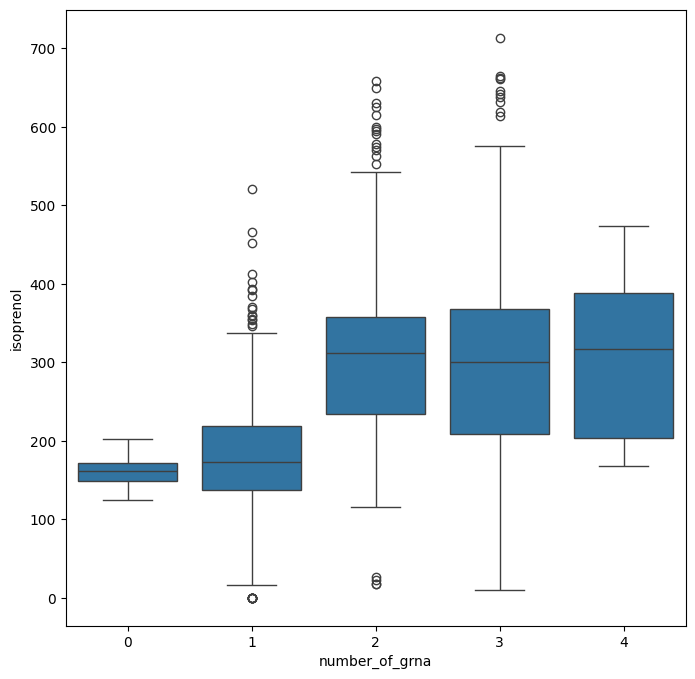

In [59]:
fig, ax = plt.subplots(figsize = (8,8))
sns.boxplot(data = df, x = 'number_of_grna', y = 'isoprenol', ax = ax)
fig.savefig(user_params['output_dir'] + 'grna_vs_titer_boxplot.png',  bbox_inches='tight')

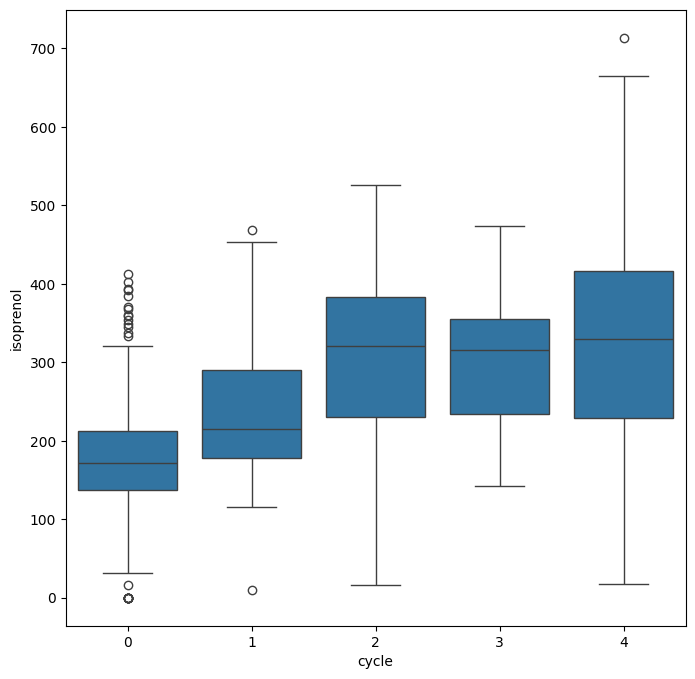

In [60]:
fig, ax = plt.subplots(figsize = (8,8))
sns.boxplot(data = df, x = 'cycle', y = 'isoprenol', ax = ax)
fig.savefig(user_params['output_dir'] + 'cycle_vs_titer_boxplot.png',  bbox_inches='tight')

<Axes: xlabel='cycle', ylabel='isoprenol'>

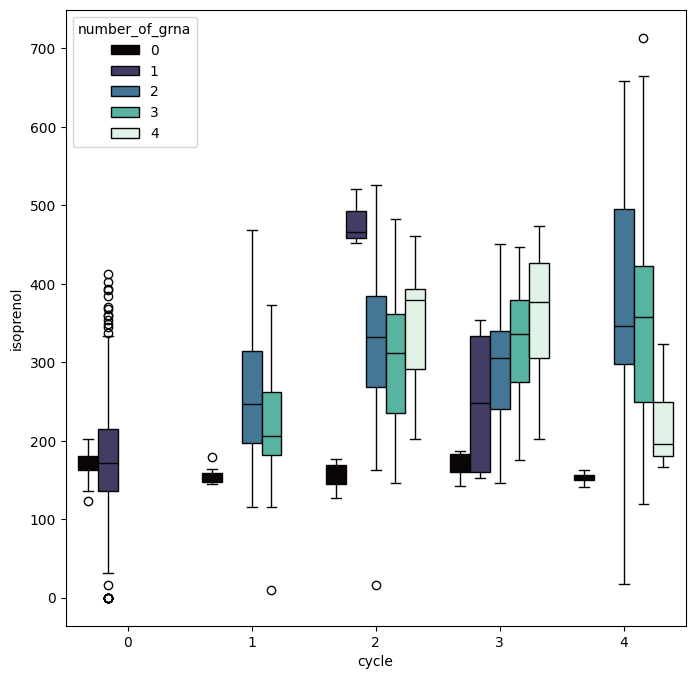

In [61]:
fig, ax = plt.subplots(figsize = (8,8))
sns.boxplot(data = df, x = 'cycle', y = 'isoprenol', hue = 'number_of_grna', palette = 'mako', ax = ax)

<Axes: xlabel='cycle', ylabel='isoprenol'>

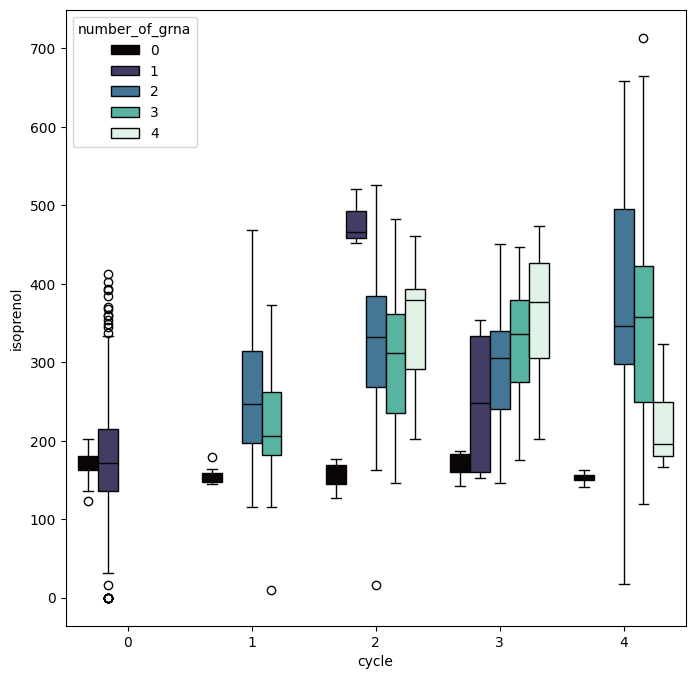

In [62]:
fig, ax = plt.subplots(figsize = (8,8))
sns.boxplot(data = df, x = 'cycle', y = 'isoprenol', hue = 'number_of_grna', palette = 'mako', ax = ax)

In [63]:
df.loc[df['cycle'] == 2, ['line_name_norep', 'isoprenol']].groupby('line_name_norep').mean().mean()

isoprenol    317.581674
dtype: float64

In [64]:
df.loc[df['cycle'] == 2, ['line_name_norep', 'isoprenol']].groupby('line_name_norep').mean().sort_values('isoprenol', ascending=False)

,isoprenol
line_name_norep,
PP_0751_PP_0814,480.646767
PP_0815_PP_1317,480.578900
PP_1317,479.387633
PP_0528_PP_0751_PP_0813,476.630833
PP_0528_PP_1769_PP_4191,466.620733
...,...
PP_0368_PP_1769,190.439533
PP_2136_PP_4189,183.626000
PP_0751_PP_4189,178.846767


In [65]:
df.loc[df['cycle'] == 0, 'number_of_grna'].value_counts()/3

number_of_grna
1    129.0
0      6.0
Name: count, dtype: float64

In [66]:
df.loc[df['cycle'] == 1, 'number_of_grna'].value_counts()/3

number_of_grna
3    30.0
2    30.0
0     4.0
Name: count, dtype: float64

In [67]:
df.loc[df['cycle'] == 2, 'number_of_grna'].value_counts()/3

number_of_grna
3    30.0
2    24.0
4     5.0
0     4.0
1     1.0
Name: count, dtype: float64

<Axes: xlabel='number_of_grna', ylabel='isoprenol'>

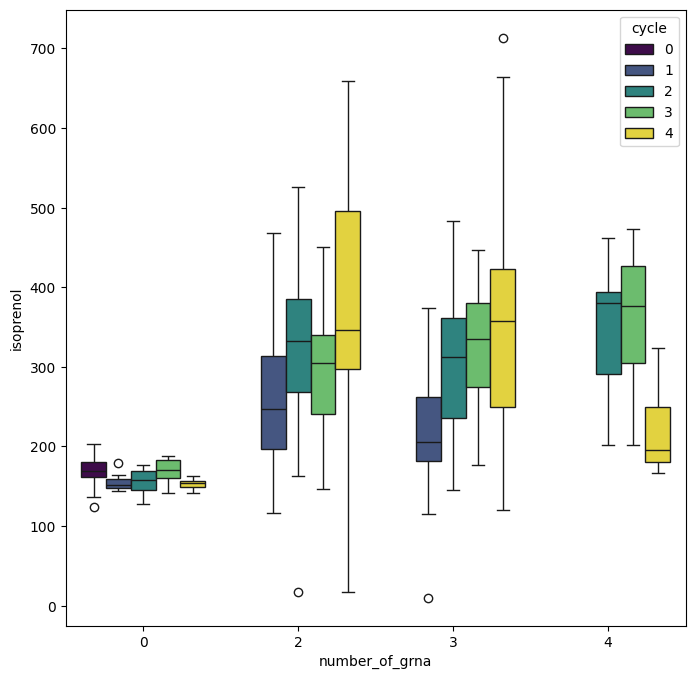

In [68]:
fig, ax = plt.subplots(figsize = (8,8))
sns.boxplot(data = df[df['number_of_grna']!=1], hue = 'cycle', y = 'isoprenol', x = 'number_of_grna', palette = 'viridis', ax = ax)

### 3.2 Compare control runs

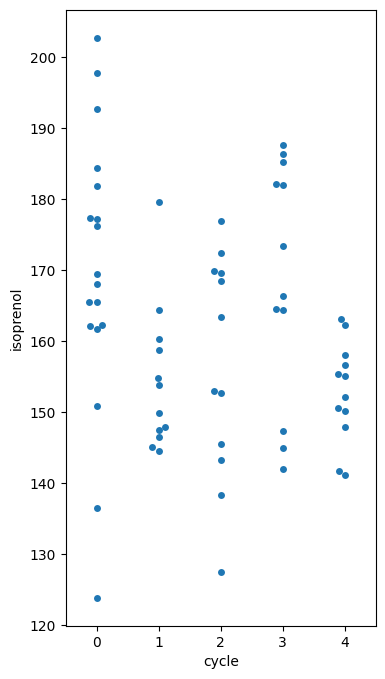

In [69]:
fig, ax = plt.subplots(figsize = (4,8))
sns.swarmplot(data = df[df['is_control']], x = 'cycle', y = 'isoprenol')
fig.savefig(user_params['output_dir'] + 'cycle_control_comparison_swarmplot.png',  bbox_inches='tight')

In [70]:
df

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,number_of_grna,dbtl1_filter,dbtl3_filter,dbtl4_filter,gRNA_1,gRNA_2,gRNA_3,gRNA_4
0,Control-R1,BL1A1_NT,mg/L,177.33700,1,Control,None,0,True,[],0,True,True,True,None,None,None,None
1,Control-R2,BL1B1_NT,mg/L,181.88373,2,Control,None,0,True,[],0,True,True,True,None,None,None,None
2,Control-R3,BL1C1_NT,mg/L,169.40580,3,Control,None,0,True,[],0,True,True,True,None,None,None,None
3,Control-R4,BL2A1_NT,mg/L,161.67620,4,Control,None,0,True,[],0,True,True,True,None,None,None,None
4,Control-R5,BL2B1_NT,mg/L,136.42987,5,Control,None,0,True,[],0,True,True,True,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,PP_1317_PP_4189-R3,DBTL4_P4_042,mg/L,236.18310,3,PP_1317_PP_4189,None,4,False,"[PP_1317, PP_4189]",2,True,True,False,PP_1317,PP_4189,None,None
1154,PP_1506_PP_4189-R3,DBTL4_P4_043,mg/L,330.69330,3,PP_1506_PP_4189,None,4,False,"[PP_1506, PP_4189]",2,True,True,True,PP_1506,PP_4189,None,None
1155,PP_4120_PP_4189-R3,DBTL4_P4_044,mg/L,16.94080,3,PP_4120_PP_4189,None,4,False,"[PP_4120, PP_4189]",2,True,True,False,PP_4120,PP_4189,None,None
1156,PP_4189_PP_4191-R3,DBTL4_P4_045,mg/L,310.26540,3,PP_4189_PP_4191,None,4,False,"[PP_4189, PP_4191]",2,True,True,False,PP_4189,PP_4191,None,None


Can check how similar the two sets of controls are. TODO: Talk about interpretation of this.

In [71]:
from scipy.stats import ttest_ind
ttest_ind(a = df[((df['is_control'] == True) & (df['cycle'] == 0))]['isoprenol'],
          b = df[((df['is_control'] == True) & (df['cycle'] == 1))]['isoprenol'])

TtestResult(statistic=2.463242240240987, pvalue=0.020178632782176124, df=28.0)

In [72]:
from scipy.stats import ttest_ind
comparisons = [[0, 1], [0, 2], [1,2], [0,3], [1,3], [2,3], [0, 4], [1, 4], [2, 4], [3, 4]]
for c in comparisons:
    a = df[((df['is_control'] == True) & (df['cycle'] == c[0]))]['isoprenol']
    b = df[((df['is_control'] == True) & (df['cycle'] == c[1]))]['isoprenol']
    s, p = ttest_ind(a = a, b = b)
    print(f"Comparison between cycle {c[0]} and cycle {c[1]}: s = {s:.3f}, p = {p:.3f}")

Comparison between cycle 0 and cycle 1: s = 2.463, p = 0.020
Comparison between cycle 0 and cycle 2: s = 1.908, p = 0.067
Comparison between cycle 1 and cycle 2: s = -0.431, p = 0.670
Comparison between cycle 0 and cycle 3: s = 0.134, p = 0.894
Comparison between cycle 1 and cycle 3: s = -2.546, p = 0.018
Comparison between cycle 2 and cycle 3: s = -1.824, p = 0.082
Comparison between cycle 0 and cycle 4: s = 2.821, p = 0.009
Comparison between cycle 1 and cycle 4: s = 0.432, p = 0.670
Comparison between cycle 2 and cycle 4: s = 0.781, p = 0.443
Comparison between cycle 3 and cycle 4: s = 3.041, p = 0.006


### 3.3 Plot all strains

In [73]:
df['line_name_norep_cycle'] = df.apply(lambda x: f"{x['line_name_norep']}_c{x['cycle']}", axis = 1)

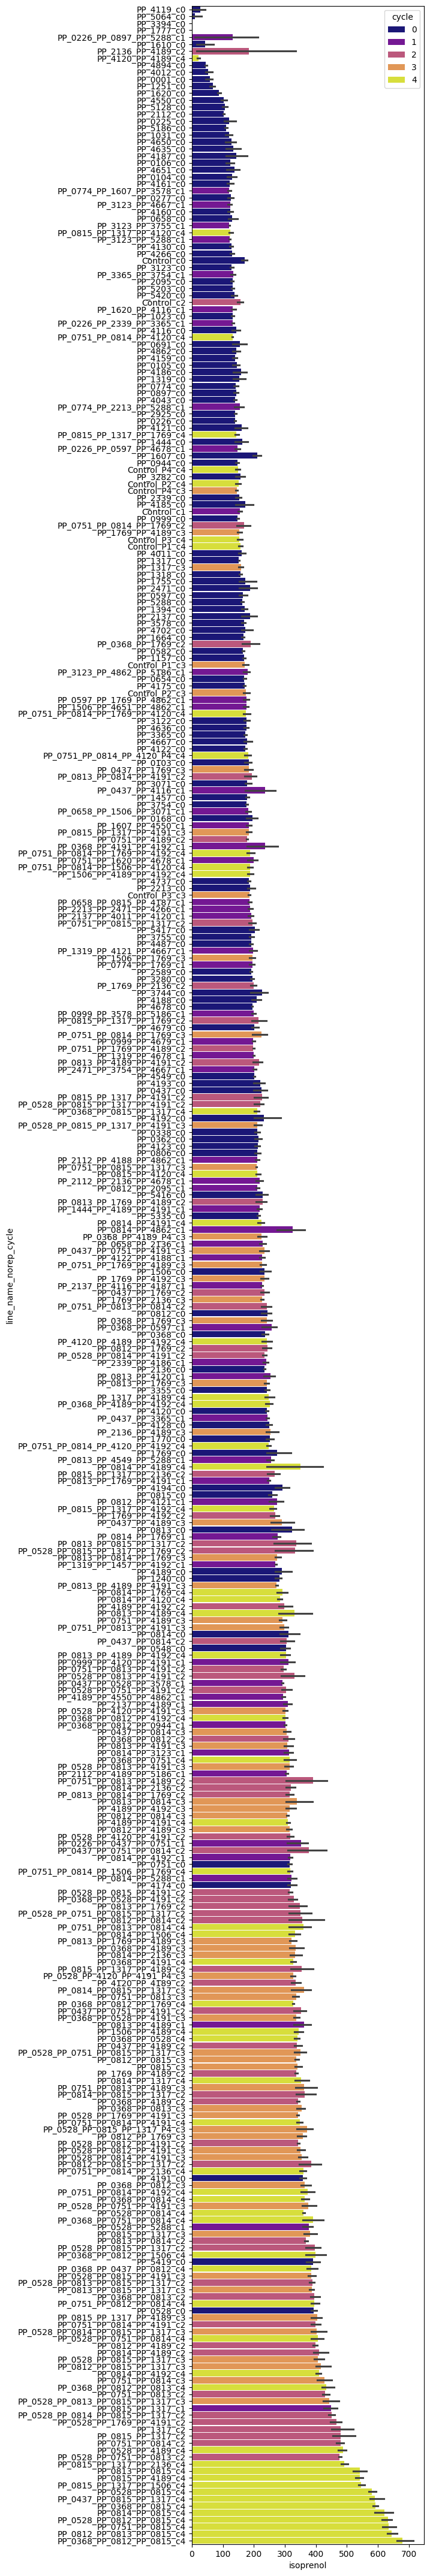

In [74]:
fig, ax = plt.subplots(figsize = (5,55))
sns.barplot(data = df.sort_values('isoprenol', ascending=True), y = 'line_name_norep_cycle', x = 'isoprenol', hue = 'cycle', ax = ax, dodge = False, width = 0.9, palette = 'plasma')
fig.savefig(user_params['output_dir'] + 'mean_bargraph_by_strain.png',  bbox_inches='tight')

### 3.4 Look for differences in control strains

In [75]:
df.loc[(df['is_control']) & (df['cycle']>0), 'control_plate'] = df.loc[df['is_control'],'Line Name'].apply(lambda x: int(x[9])).astype(int)

<Axes: xlabel='cycle', ylabel='isoprenol'>

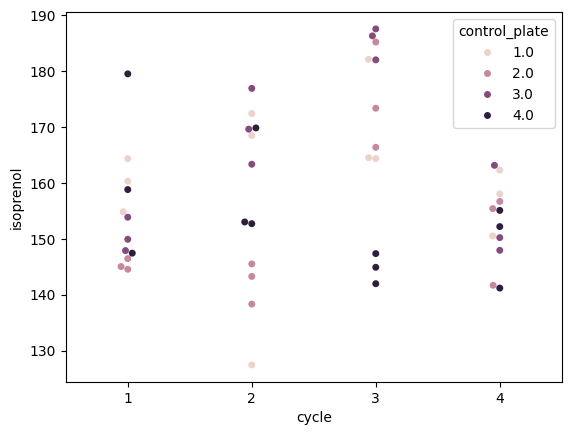

In [76]:
sns.swarmplot(data = df.loc[(df['is_control']) & (df['cycle'] >0 ),:],   x = 'cycle', y = 'isoprenol', hue = 'control_plate')

In [77]:
control_df = df.loc[(df['is_control']) & (df['cycle'] >-1 ),:].copy()
cycle0_plate_list = pd.read_excel('./DBTL0_data/sample injection order.xlsx')
plate_dict = dict(zip(cycle0_plate_list['Sample Name in order injected'], cycle0_plate_list['Batch number']))
control_df.loc[control_df['cycle']==0,'control_plate'] = control_df.loc[control_df['cycle']==0,'Line Name'].apply(lambda x: plate_dict[x])
control_df['control_plate'] = control_df['control_plate'].astype(int)

<Axes: xlabel='isoprenol', ylabel='plate_cycle'>

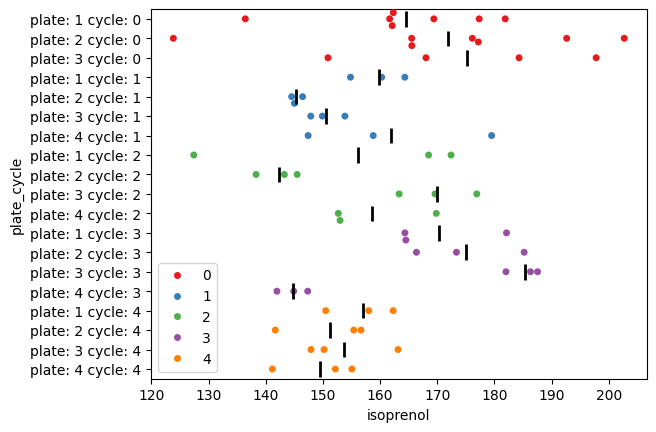

In [78]:
control_df['plate_cycle'] = control_df.apply(lambda x: f"plate: {int(x['control_plate'])} cycle: {x['cycle']}", axis = 1)
control_df
p=sns.swarmplot(data = control_df,   y = 'plate_cycle', x = 'isoprenol', hue = 'cycle', palette = 'Set1')

# p = sns.stripplot(x="method", y="distance", data=planets, size=4, color=".7")
# plt.xticks(rotation=45, ha="right")
# p.set(yscale='log')

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="isoprenol",
            y="plate_cycle",
            data=control_df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)

In [79]:
pctcv_df = pd.DataFrame(columns = ['cycle','plate', 'mean', 'std', 'pctcv'])
pctcv_df['cycle'] = [0,0,0,1,1,1,1,2,2,2,2, 3,3,3,3, 4,4,4,4]
pctcv_df['plate'] = [1,2,3,1,2,3,4,1,2,3,4, 1,2,3,4, 1,2,3,4]
for idx, srs in pctcv_df.iterrows():
    pctcv_df.loc[idx, 'mean'] = control_df.loc[(control_df['is_control']) & (control_df['cycle'] == srs['cycle']) & (control_df['control_plate']==srs['plate']), 'isoprenol'].mean()
    pctcv_df.loc[idx, 'std'] = control_df.loc[(control_df['is_control']) & (control_df['cycle'] == srs['cycle']) & (control_df['control_plate']==srs['plate']), 'isoprenol'].std()
    
pctcv_df['pctcv'] =100* pctcv_df['std']/pctcv_df['mean']

<Axes: xlabel='cycle', ylabel='pctcv'>

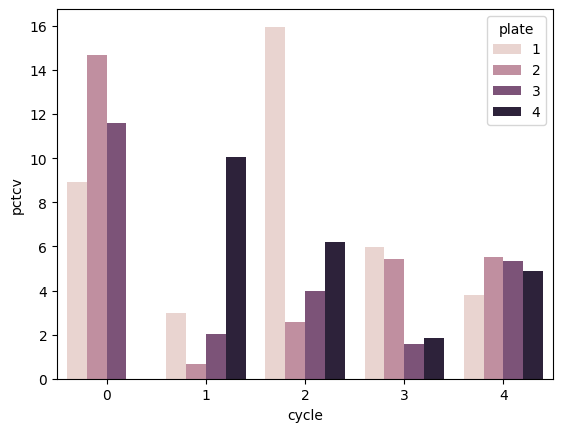

In [80]:
pctcv_df
sns.barplot(data = pctcv_df, x = 'cycle', hue = 'plate', y = 'pctcv')

## 4. Prepare data for ART

In [81]:
all_perturbed_genes = df[((df['cycle'] == 0) & (df['is_control'] == False))]['line_name_norep'].unique()
all_perturbed_genes
print(f'There are N = {len(all_perturbed_genes)} from DBTL0. \nAll perturbed genes from DBTL0: \n{all_perturbed_genes}')

There are N = 121 from DBTL0. 
All perturbed genes from DBTL0: 
['PP_0001' 'PP_0103' 'PP_0104' 'PP_0105' 'PP_0106' 'PP_0168' 'PP_0225'
 'PP_0226' 'PP_0277' 'PP_0338' 'PP_0362' 'PP_0368' 'PP_0437' 'PP_0528'
 'PP_0548' 'PP_0582' 'PP_0597' 'PP_0654' 'PP_0658' 'PP_0691' 'PP_0751'
 'PP_0774' 'PP_0806' 'PP_0812' 'PP_0813' 'PP_0814' 'PP_0815' 'PP_0897'
 'PP_0944' 'PP_0999' 'PP_1023' 'PP_1031' 'PP_1157' 'PP_1240' 'PP_1251'
 'PP_1317' 'PP_1318' 'PP_1319' 'PP_1394' 'PP_1444' 'PP_1457' 'PP_1506'
 'PP_1607' 'PP_1610' 'PP_1620' 'PP_1664' 'PP_1755' 'PP_1769' 'PP_1770'
 'PP_1777' 'PP_2095' 'PP_2112' 'PP_2136' 'PP_2137' 'PP_2213' 'PP_2339'
 'PP_2471' 'PP_2589' 'PP_2925' 'PP_3071' 'PP_3122' 'PP_3123' 'PP_3280'
 'PP_3282' 'PP_3355' 'PP_3365' 'PP_3394' 'PP_3578' 'PP_3744' 'PP_3754'
 'PP_3755' 'PP_4011' 'PP_4012' 'PP_4043' 'PP_4116' 'PP_4119' 'PP_4120'
 'PP_4121' 'PP_4122' 'PP_4123' 'PP_4128' 'PP_4130' 'PP_4159' 'PP_4160'
 'PP_4161' 'PP_4174' 'PP_4175' 'PP_4185' 'PP_4186' 'PP_4187' 'PP_4188'
 'PP_4189' 'P

Create function to return 1 if a gene is in the sorted gene list else return 0.

In [82]:
def check_if_gene_in_list(gene_list, gene):
    if gene in list(gene_list):
        return 1
    else:
        return 0

Iterate through each gene column and fill it in by applying `check_if_gene_in_list` for that specific gene (argument `perturbed_gene`).

In [83]:
from warnings import simplefilter 
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
for perturbed_gene in all_perturbed_genes:
    df.loc[:,perturbed_gene] = df['sorted_gene_list'].apply(lambda x: check_if_gene_in_list(x, perturbed_gene)).astype(int)

### 4.2 Sanity checks for converting gene list to feature

Each 'PP_XXXX' column is a binary indicator of whether that gene was perturbed - so the sum of all PP_ columns should equal the number of gRNAs for each line:

In [84]:
sum_binary_gene_columns = df.loc[:, all_perturbed_genes].sum(axis = 1)
assert(np.all(sum_binary_gene_columns.values == df['number_of_grna'].values)), 'ERROR: binary features do not match number_of_grna column in dataframe.'

No PP_XXXX columns should be empty, because they were created as a list of all genes that were perturbed.

In [85]:
sum_binary_gene_rows = df.loc[:, all_perturbed_genes].sum(axis = 0)
assert(min(sum_binary_gene_rows)>=3), 'ERROR: At least one gRNA column is completely empty.'

### 4.3 Identify genes to pass to ART
ART will not be able to learn very much from genes that only appear by themselves in DBTL0. Thus, we will identify only those genes that are present in DBTL1 (in double or triple gRNA lines), and only use those genes with ART.

We will additionally add control datapoints (with no gRNA) to pass to ART.

Get list of genes perturbed in DBTL1

In [86]:
cycle1_perturbed_genes = np.sort(np.unique(np.concatenate(df.loc[df['cycle'] == 1, 'sorted_gene_list'].values, axis = 0)))
cycle1_perturbed_genes

array(['PP_0226', 'PP_0368', 'PP_0437', 'PP_0528', 'PP_0597', 'PP_0658',
       'PP_0751', 'PP_0774', 'PP_0812', 'PP_0813', 'PP_0814', 'PP_0815',
       'PP_0897', 'PP_0944', 'PP_0999', 'PP_1317', 'PP_1319', 'PP_1444',
       'PP_1457', 'PP_1506', 'PP_1607', 'PP_1620', 'PP_1769', 'PP_2095',
       'PP_2112', 'PP_2136', 'PP_2137', 'PP_2213', 'PP_2339', 'PP_2471',
       'PP_3071', 'PP_3123', 'PP_3365', 'PP_3578', 'PP_3754', 'PP_3755',
       'PP_4011', 'PP_4116', 'PP_4120', 'PP_4121', 'PP_4122', 'PP_4186',
       'PP_4187', 'PP_4188', 'PP_4189', 'PP_4191', 'PP_4192', 'PP_4266',
       'PP_4549', 'PP_4550', 'PP_4651', 'PP_4667', 'PP_4678', 'PP_4679',
       'PP_4862', 'PP_5186', 'PP_5288'], dtype='<U32')

Add indicator variable for whether a line has a gRNA from cycle 1 or not.

In [87]:
check_for_cycle1_gene = lambda gene_list: 1 if np.any([single_gene in cycle1_perturbed_genes for single_gene in gene_list]) else 0
df['has_cycle1_gene'] = df['sorted_gene_list'].apply(check_for_cycle1_gene).astype(bool)

Use `is_control` and `has_cycle1_gene` to determine whether to pass the data to ART. 

In [88]:
df

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,...,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,PP_5420,has_cycle1_gene
0,Control-R1,BL1A1_NT,mg/L,177.33700,1,Control,None,0,True,[],...,0,0,0,0,0,0,0,0,0,False
1,Control-R2,BL1B1_NT,mg/L,181.88373,2,Control,None,0,True,[],...,0,0,0,0,0,0,0,0,0,False
2,Control-R3,BL1C1_NT,mg/L,169.40580,3,Control,None,0,True,[],...,0,0,0,0,0,0,0,0,0,False
3,Control-R4,BL2A1_NT,mg/L,161.67620,4,Control,None,0,True,[],...,0,0,0,0,0,0,0,0,0,False
4,Control-R5,BL2B1_NT,mg/L,136.42987,5,Control,None,0,True,[],...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,PP_1317_PP_4189-R3,DBTL4_P4_042,mg/L,236.18310,3,PP_1317_PP_4189,None,4,False,"[PP_1317, PP_4189]",...,0,0,0,0,0,0,0,0,0,True
1154,PP_1506_PP_4189-R3,DBTL4_P4_043,mg/L,330.69330,3,PP_1506_PP_4189,None,4,False,"[PP_1506, PP_4189]",...,0,0,0,0,0,0,0,0,0,True
1155,PP_4120_PP_4189-R3,DBTL4_P4_044,mg/L,16.94080,3,PP_4120_PP_4189,None,4,False,"[PP_4120, PP_4189]",...,0,0,0,0,0,0,0,0,0,True
1156,PP_4189_PP_4191-R3,DBTL4_P4_045,mg/L,310.26540,3,PP_4189_PP_4191,None,4,False,"[PP_4189, PP_4191]",...,0,0,0,0,0,0,0,0,0,True


In [89]:
df[
    (df['cycle']==4) & 
(df['dbtl4_filter'])
]

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,...,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,PP_5420,has_cycle1_gene
972,PP_0368_PP_0812_PP_0813-R1,DBTL4_P1_001,mg/L,458.8593,1,PP_0368_PP_0812_PP_0813,None,4,False,"[PP_0368, PP_0812, PP_0813]",...,0,0,0,0,0,0,0,0,0,True
973,PP_0368_PP_0812_PP_0815-R1,DBTL4_P1_002,mg/L,713.6108,1,PP_0368_PP_0812_PP_0815,None,4,False,"[PP_0368, PP_0812, PP_0815]",...,0,0,0,0,0,0,0,0,0,True
974,PP_0751_PP_0812_PP_0814-R1,DBTL4_P1_003,mg/L,410.4078,1,PP_0751_PP_0812_PP_0814,None,4,False,"[PP_0751, PP_0812, PP_0814]",...,0,0,0,0,0,0,0,0,0,True
975,PP_0751_PP_0813_PP_0814-R1,DBTL4_P1_004,mg/L,313.9162,1,PP_0751_PP_0813_PP_0814,None,4,False,"[PP_0751, PP_0813, PP_0814]",...,0,0,0,0,0,0,0,0,0,True
976,PP_0751_PP_0814_PP_4191-R1,DBTL4_P1_005,mg/L,351.5461,1,PP_0751_PP_0814_PP_4191,None,4,False,"[PP_0751, PP_0814, PP_4191]",...,0,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,PP_1506_PP_4189-R2,DBTL4_P4_035,mg/L,357.1915,2,PP_1506_PP_4189,None,4,False,"[PP_1506, PP_4189]",...,0,0,0,0,0,0,0,0,0,True
1151,Control_P4-R2,DBTL4_P4_040,mg/L,152.1780,2,Control_P4,None,4,True,[],...,0,0,0,0,0,0,0,0,0,False
1152,PP_0815_PP_4189-R3,DBTL4_P4_041,mg/L,552.4192,3,PP_0815_PP_4189,None,4,False,"[PP_0815, PP_4189]",...,0,0,0,0,0,0,0,0,0,True
1154,PP_1506_PP_4189-R3,DBTL4_P4_043,mg/L,330.6933,3,PP_1506_PP_4189,None,4,False,"[PP_1506, PP_4189]",...,0,0,0,0,0,0,0,0,0,True


In [90]:
df['cycle']

0       0
1       0
2       0
3       0
4       0
       ..
1153    4
1154    4
1155    4
1156    4
1157    4
Name: cycle, Length: 1158, dtype: int64

In [91]:
# df.loc[:,'pass_to_art'] = np.logical_and(
#     np.logical_or(
#         df['is_control'], df['has_cycle1_gene']
#     ), 
#     df['dbtl1_filter'],
#     df['dbtl3_filter'],
#     df['cycle'].isin([0,1,3])
# )
CYCLES_TO_KEEP = [3,4]
df.loc[:,'pass_to_art'] = (
    (df['is_control'] | df['has_cycle1_gene']) &
    (df['dbtl1_filter']) &
    (df['dbtl3_filter']) &
    (df['dbtl4_filter']) &
    (df['cycle'].isin(CYCLES_TO_KEEP))
).astype(bool)

print(f"Considering which datapoints to pass to ART:\nThere are N = {np.sum(df['pass_to_art'])} to pass to art\n"
      f"There are N = {np.sum(df['is_control'])} control datapoints\n"
      f"There are N = {np.sum(df['has_cycle1_gene'])} datapoints with a cycle 1 gene.")
print(f"'Cycle' valuecounts for df['pass_to_art'] == True:\n{df.loc[df['pass_to_art'], 'cycle'].value_counts()}")
df.head(3)

Considering which datapoints to pass to ART:
There are N = 150 to pass to art
There are N = 66 control datapoints
There are N = 897 datapoints with a cycle 1 gene.
'Cycle' valuecounts for df['pass_to_art'] == True:
cycle
4    78
3    72
Name: count, dtype: int64


,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,...,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,PP_5420,has_cycle1_gene,pass_to_art
0,Control-R1,BL1A1_NT,mg/L,177.33700,1,Control,None,0,True,[],...,0,0,0,0,0,0,0,0,False,False
1,Control-R2,BL1B1_NT,mg/L,181.88373,2,Control,None,0,True,[],...,0,0,0,0,0,0,0,0,False,False
2,Control-R3,BL1C1_NT,mg/L,169.40580,3,Control,None,0,True,[],...,0,0,0,0,0,0,0,0,False,False


In [92]:
df[df['pass_to_art']].value_counts('cycle')

cycle
4    78
3    72
Name: count, dtype: int64

In [93]:
# assert np.sum(df['pass_to_art']) == (np.sum(df['is_control']) + np.sum(df['has_cycle1_gene'])), 'ERROR: number of datapoints passed to ART should equal number of "is_control" and number of "has_cycle1_gene".'

### 4.4 Ignore non-template strands in ART
Some gRNA were modified with different non-template gRNA - we will ignore these for ART.

If any datapoints with `pass_to_art` == 1 have an `nt_string`, change `pass_to_art` to 0. 

In [94]:
check_for_nt_string = lambda x: True if x is None else False
df.loc[df['pass_to_art'], 'pass_to_art'] = df['nt_string'].apply(check_for_nt_string)

### 4.5 Drop cycle 2 data

In [95]:
df = df.loc[df['cycle'].isin(CYCLES_TO_KEEP), :]

### 4.5 Update control line names
Controls from DBTL0 and DBTL1 have identical names.

In [96]:
n_dbtl0_controls = len(df[(df['is_control']) & (df['cycle'] == 0)])
n_dbtl1_controls = len(df[(df['is_control']) & (df['cycle'] == 1)])
n_dbtl3_controls = len(df[(df['is_control']) & (df['cycle'] == 3)])
n_dbtl4_controls = len(df[(df['is_control']) & (df['cycle'] == 4)])
print(f'DBTL0 controls: N = {n_dbtl0_controls}\tDBTL1 controls: N = {n_dbtl1_controls}\tDBTL3 controls: N = {n_dbtl3_controls}\tDBTL4 controls: N = {n_dbtl4_controls}')

DBTL0 controls: N = 0	DBTL1 controls: N = 0	DBTL3 controls: N = 12	DBTL4 controls: N = 12


In [97]:
import re

DBTL1 and DBTL3 controls are labeled by both plate and rep number, so there are actually 12 different controls from DBTL1 that need to be named with different reps.

In [98]:
def update_control_replicates(x):
    plate_number = int(x['Line Name'][re.search('_P', x['Line Name']).end()])
    rep_number = int(x['Line Name'][re.search('-R', x['Line Name']).end()])
    dbtl1_rep = (plate_number-1)*3+rep_number
    return dbtl1_rep

In [99]:
dbtl3_control_idx = ((df['is_control'] == True) & (df['cycle'] == 3))
df.loc[dbtl3_control_idx, 'rep'] = df.loc[dbtl3_control_idx,:].apply(update_control_replicates, axis = 1)

dbtl4_control_idx = ((df['is_control'] == True) & (df['cycle'] == 4))
df.loc[dbtl4_control_idx, 'rep'] = df.loc[dbtl4_control_idx,:].apply(update_control_replicates, axis = 1)

Add cumulative rep column to track control replicates across experiments

In [100]:
df.loc[:,'cumulative_rep'] = df.loc[:,'rep']

/tmp/ipykernel_18727/3986007594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'cumulative_rep'] = df.loc[:,'rep']


In [101]:
df.loc[dbtl4_control_idx, 'cumulative_rep'] = df.loc[dbtl4_control_idx, 'cumulative_rep'] + n_dbtl3_controls

### 4.6 Check for any other repeat strains


In [102]:
for ln in df.loc[~df['is_control'],'line_name_norep'].unique():
    line_cycles = np.sort(df.loc[df['line_name_norep'] == ln, 'cycle'].unique())
    if len(line_cycles)>1: #Need to update cumulative_rep for the extra cycles
        print(f'Found non-control line name: {ln} in cycles: {line_cycles}.') 
        n_reps_counted = 0
        for cycle_index, cycle in enumerate(line_cycles):
            line_cycle_index = (df['line_name_norep'] == ln) & (df['cycle'] == cycle)
            df.loc[line_cycle_index, 'cumulative_rep'] += n_reps_counted
            n_reps_counted+=sum(line_cycle_index)
        
        print(f"After updating cumulative_reps, we have the following cumulative_reps: {df.loc[df['line_name_norep']==ln, 'cumulative_rep'].unique()}")

In [103]:
df.loc[:,'cumulative_rep'] = df.loc[:,'cumulative_rep'].astype(int)

### 4.6 Write line names for ART
Want to write line names based on 

- `line_name_norep` which contains the line name with no extra information (Plate/non-template strings removed)
- `rep` which contains the rep number

In [104]:
df.loc[df['is_control'], ['cycle', 'line_name_norep', 'rep', 'cumulative_rep']]

,cycle,line_name_norep,rep,cumulative_rep
820,3,Control_P1,1,1
828,3,Control_P1,2,2
836,3,Control_P1,3,3
868,3,Control_P2,4,4
876,3,Control_P2,5,5
884,3,Control_P2,6,6
916,3,Control_P3,7,7
924,3,Control_P3,8,8
932,3,Control_P3,9,9
961,3,Control_P4,10,10


In [105]:
df.tail()

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,...,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,PP_5420,has_cycle1_gene,pass_to_art,cumulative_rep
1153,PP_1317_PP_4189-R3,DBTL4_P4_042,mg/L,236.1831,3,PP_1317_PP_4189,None,4,False,"[PP_1317, PP_4189]",...,0,0,0,0,0,0,0,True,False,3
1154,PP_1506_PP_4189-R3,DBTL4_P4_043,mg/L,330.6933,3,PP_1506_PP_4189,None,4,False,"[PP_1506, PP_4189]",...,0,0,0,0,0,0,0,True,True,3
1155,PP_4120_PP_4189-R3,DBTL4_P4_044,mg/L,16.9408,3,PP_4120_PP_4189,None,4,False,"[PP_4120, PP_4189]",...,0,0,0,0,0,0,0,True,False,3
1156,PP_4189_PP_4191-R3,DBTL4_P4_045,mg/L,310.2654,3,PP_4189_PP_4191,None,4,False,"[PP_4189, PP_4191]",...,0,0,0,0,0,0,0,True,False,3
1157,Control_P4-R3,DBTL4_P4_048,mg/L,155.0741,12,Control_P4,None,4,True,[],...,0,0,0,0,0,0,0,False,True,24


In [106]:
add_rep_to_line_name = lambda x: '-'.join((x['line_name_norep'], 'R'+str(x['cumulative_rep'])))
df.loc[:,'line_name_art'] = df.apply(add_rep_to_line_name, axis = 1)

/tmp/ipykernel_18727/3444253678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'line_name_art'] = df.apply(add_rep_to_line_name, axis = 1)


In [107]:
df.head(3)

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,...,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,PP_5420,has_cycle1_gene,pass_to_art,cumulative_rep,line_name_art
789,PP_0528_PP_0813_PP_0815_PP_1317-R1,DBTL3_P1_001,mg/L,473.4303,1,PP_0528_PP_0813_PP_0815_PP_1317,None,3,False,"[PP_0528, PP_0813, PP_0815, PP_1317]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0813_PP_0815_PP_1317-R1
790,PP_0528_PP_0813_PP_4191-R1,DBTL3_P1_002,mg/L,325.8933,1,PP_0528_PP_0813_PP_4191,None,3,False,"[PP_0528, PP_0813, PP_4191]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0813_PP_4191-R1
791,PP_0528_PP_0814_PP_4191-R1,DBTL3_P1_003,mg/L,372.1794,1,PP_0528_PP_0814_PP_4191,None,3,False,"[PP_0528, PP_0814, PP_4191]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0814_PP_4191-R1


In [108]:
df['line_name_art'].value_counts()

line_name_art
PP_0528_PP_0813_PP_0815_PP_1317-R1    1
PP_0751_PP_0814_PP_4120_PP_4192-R2    1
PP_0368_PP_0437_PP_0812-R3            1
PP_0751_PP_0814_PP_4120_PP_4192-R3    1
PP_0751_PP_0814_PP_1769_PP_4192-R3    1
                                     ..
PP_0528_PP_0815_PP_1317_PP_4191-R1    1
PP_0368_PP_0812-R1                    1
PP_1769_PP_4192-R3                    1
PP_0437_PP_1769-R3                    1
Control_P4-R24                        1
Name: count, Length: 369, dtype: int64

Save dataframe as a pickle

In [109]:
df.to_pickle(user_params['output_dir'] + 'dbtl3_dbtl4_isoprenol_processed_df.pkl')

### 4.7 Melt dataframe to format for ART
ART runs on a dataframe with three columns: 

- Line Name: A unique identifier for each line with any -RX denoting a replicate measurement
- Type: the name of the variable, ex: 'PP_0461' (a binary variable) or 'isoprenol' (a continuous variable)
- '0.0': The numeric value of the variable - the column name 0.0 indicates time.  

We can use the `pd.melt()` function ([docs at this link](https://pandas.pydata.org/docs/reference/api/pandas.melt.html)) to turn a wide-form dataframe into a tall-form dataframe. In the function, `id_vars` are kept as identifiers for each datapoint in the tall dataframe. The value of each column passed to `value_vars` is also kept in the dataframe.  

In [110]:
values_to_melt = cycle1_perturbed_genes.tolist() + ['isoprenol']
df_art = pd.melt(df[df['pass_to_art']==1], id_vars = 'line_name_art', var_name = 'Type', value_vars = values_to_melt, value_name='0.0')
df_art = df_art.rename(columns={'line_name_art': 'Line Name'})

In [111]:
sum(df_art['Line Name'].value_counts()==116)

0

### 4.7 Set up ART parameters
ART expects a dictionary of parameters that we need to set up.

ART bounds are defined as a dataframe with columns: ['Variable', 'Min', 'Max']

In [112]:
art_bounds_dict = {'Variable': cycle1_perturbed_genes,
                   'Min': int(0),
                   'Max': int(1)
                  }
art_bounds = pd.DataFrame(art_bounds_dict)
art_bounds.head(3)

,Variable,Min,Max
0,PP_0226,0,1
1,PP_0368,0,1
2,PP_0437,0,1


In [113]:
art_params = {'input_vars': cycle1_perturbed_genes.tolist(),
              'input_var_type': 'categorical', #Only binary values will be chose by ART
              'bounds': art_bounds,
              'scale_input_vars': False,
              'response_vars': ['isoprenol'],
              'build_model': True,
              'cross_val': True,
              'cross_val_partitions': 5,
              'recommend': False, #We will use the trained model to evaluate recommendations outside of ARTs API.
              'output_dir': './dbtl4_art_outputs',
              'verbose': 0,
              'testing': False,
              'initial_cycle': False,
              'last_dashes_denote_replicates': True,
              'seed': 42}

Print some important ART parameters:

In [114]:
if art_params['cross_val']:
    print(f"Running cross_validation with N = {art_params['cross_val_partitions']} partitions.")
else:
    print("Not running cross_validation")

if not art_params['recommend']:
    print("Skipping ART recommendations")

Running cross_validation with N = 5 partitions.
Skipping ART recommendations


## 5. Run ART

In [115]:
art_filename = art_params['output_dir'] + '/art.cpkl'
print(f'ART cloudpickle filename: {art_filename}')
art_file_exists = os.path.exists(art_filename)

ART cloudpickle filename: ./dbtl4_art_outputs/art.cpkl


ART cloudpickle not found -- Running ART
ART identified 46 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.


/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.

/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian

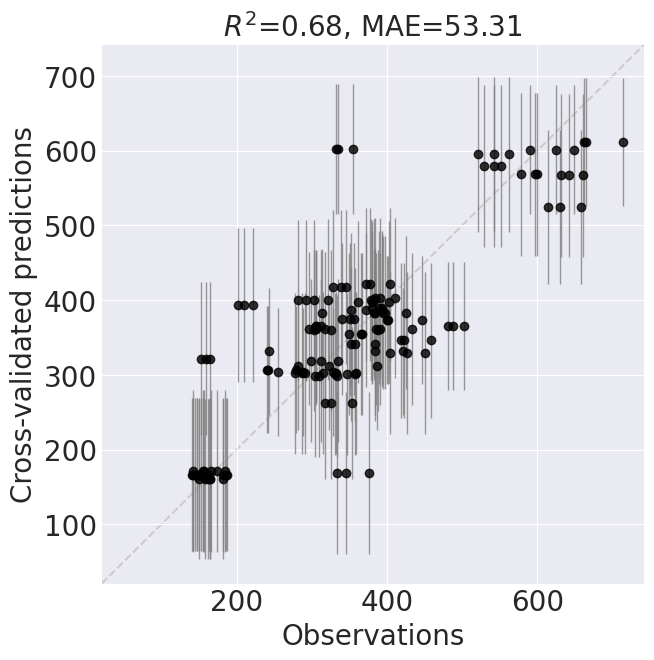

Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Cons

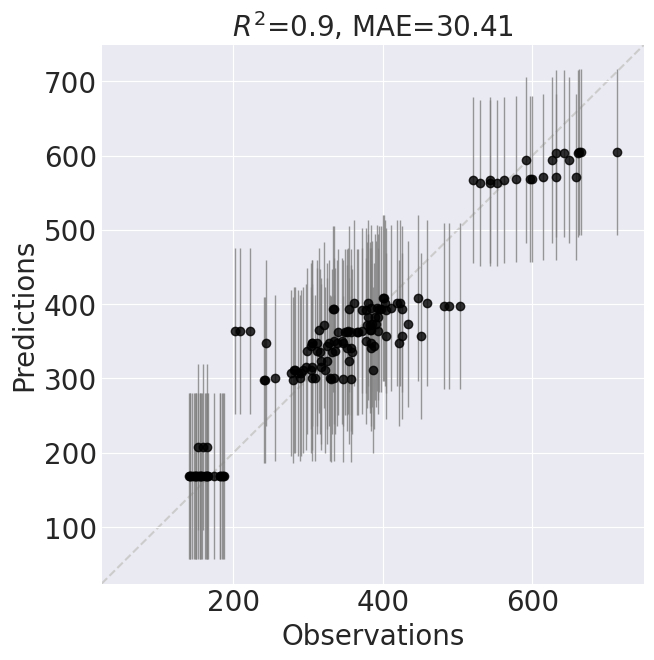

In [116]:
if art_file_exists:
    import cloudpickle as cloudpickle
    print(f'Found ART file: {art_filename}')
    with open(art_filename, 'rb') as output:
        art = cloudpickle.load(output)
else:
    print('ART cloudpickle not found -- Running ART')
    art = RecommendationEngine(df = df_art, **art_params)

## 6. Use trained model to evaluate designs
ART's built in categorical optimizer and recommender evaluates all possible combinations of 5 gRNA.

Import itertools to create combinations of genes.

In [117]:
import itertools

Use itertools to make all combinations of numbers up to `len(total_gRNA)` with length 5 or shorter

In [118]:
total_gRNA = len(cycle1_perturbed_genes)
grna_indices = np.arange(total_gRNA)
max_number_grna = user_params['max_guide_rnas']
all_possible_designs = []
for l in np.arange(0,max_number_grna+1):
    all_possible_designs.append(list(itertools.combinations(grna_indices,l)))
    
print('Printing up to the first 10 designs for each length L')
for design_list in all_possible_designs:
    print(f'First N possible designs with length: {len(design_list[0])} = {design_list[:10]}')

Printing up to the first 10 designs for each length L
First N possible designs with length: 0 = [()]
First N possible designs with length: 1 = [(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,)]
First N possible designs with length: 2 = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10)]
First N possible designs with length: 3 = [(0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 1, 7), (0, 1, 8), (0, 1, 9), (0, 1, 10), (0, 1, 11)]
First N possible designs with length: 4 = [(0, 1, 2, 3), (0, 1, 2, 4), (0, 1, 2, 5), (0, 1, 2, 6), (0, 1, 2, 7), (0, 1, 2, 8), (0, 1, 2, 9), (0, 1, 2, 10), (0, 1, 2, 11), (0, 1, 2, 12)]


Flatten the list of lists:

In [119]:
all_possible_designs = [item for sublist in all_possible_designs for item in sublist]
print(f'There are N={len(all_possible_designs)} total combinations')

There are N=425924 total combinations


Convert into a binary array which can be passed to ART

In [120]:
binary_designs = np.zeros((len(all_possible_designs), total_gRNA)).astype(int)
for i, c in enumerate(all_possible_designs):
    binary_designs[i,c] = 1

Print some designs to demonstrate how algorithm works.

In [121]:
designs_to_print = np.floor(np.linspace(0, len(all_possible_designs)-1, 5)).astype(int)

print(f"Printing some designs from binary_designs:")
for design_idx in designs_to_print:
    print(f"Design #{design_idx}\n{binary_designs[design_idx,:]}\n")
print(f"Number of times each gene shows up in designs: {np.unique(np.sum(binary_designs, axis = 0))}")
print(f"Number of nonzero entries in designs: {np.unique(np.sum(binary_designs, axis = 1))}")
print(f"Shape of binary designs: {binary_designs.shape}")

Printing some designs from binary_designs:
Design #0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Design #106480
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Design #212961
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]

Design #319442
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Design #425923
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]

Number of times each gene shows up in designs: [29317]
Number of nonzero entries in designs: [0 1 2 3 4]
Shape of binary designs: (425924, 57)


### 6.1 Sanity checks for generating combinations
- All genes should show up the same number of times.
- The sum of each combination should be between 0 and 5

In [122]:
assert(len(np.unique(np.sum(binary_designs, axis = 0))) == 1), 'Error generating designs - all genes should show up the same number of times'
assert(np.all(np.sort(np.unique(np.sum(binary_designs, axis = 1))) == np.arange(user_params['max_guide_rnas']+1))), 'Error generating designs - The sum of each combination should be between 0 and max_guide_rnas'

## 7. Pass possible designs to ART
Note that depending on designs, this can be very slow. On a Macbook M1 with all gRNA combinations up to length 5, it took 3 hours. So, we will check if `DBTL1_rec_df.pkl` exists before rerunning the code. 

In [123]:
rec_df_filename = user_params['output_dir'] + 'dbtl4_rec_df_filtered_training_data.pkl'
print(f'rec_df_filename: {rec_df_filename}')
rec_file_exists = os.path.exists(rec_df_filename)

rec_df_filename: ./dbtl4_figures_and_analysis/dbtl0_dbtl1_dbtl3_rec_df_filtered_training_data.pkl


If we did not find a recommendation file, run each possible design (`binary_designs`) through `art.post_pred_stats()` to get the predicted mean and standard deviation for that recommendation.

In [124]:
if rec_file_exists:
    print(f'Found rec file: {rec_df_filename}')
    rec_df = pd.read_pickle(rec_df_filename)

else:
    print(f'No rec file found. Processing recommendations')
    pp_mean, pp_std = [np.zeros((binary_designs.shape[0],1)), np.zeros((binary_designs.shape[0],1))]
    from tqdm import tqdm
    for idx, design in enumerate(tqdm(binary_designs)):
        m,s = art.post_pred_stats(design)
        pp_mean[idx] = m
        pp_std[idx] = s
    rec_df = pd.DataFrame(columns = list(cycle1_perturbed_genes) + ['pp_mean', 'pp_std'],
                         data = np.hstack([binary_designs, pp_mean, pp_std])) 
    rec_df.to_pickle(rec_df_filename)

No rec file found. Processing recommendations


100%|██████████| 425924/425924 [19:51<00:00, 357.55it/s]


In [125]:
rec_df

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4550,PP_4651,PP_4667,PP_4678,PP_4679,PP_4862,PP_5186,PP_5288,pp_mean,pp_std
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,168.436308,56.996703
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,191.913884,57.000846
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.207387,57.134537
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.029513,57.039585
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.320149,57.059118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,292.318665,57.151255
425920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,292.318665,57.151255
425921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,292.318665,57.151255
425922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,292.318665,57.151255
